In [656]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16 # was 28

# text
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

colour_ro = u'#d62728' #red
colour_spline = u'#1f77b4' #blue
colour_aux_1 = u'#ff7f0e' #orange
colour_aux_2 = u'#2ca02c' #green
colour_ins = 'black' #black

In [657]:
dataset_path = "/tmp/"
INS_relative_poses_path = dataset_path+"flattened_novatel_generated_poses.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
     
print("\nFinished importing.")

reading INS_relative_poses_path: /tmp/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2

Finished importing.


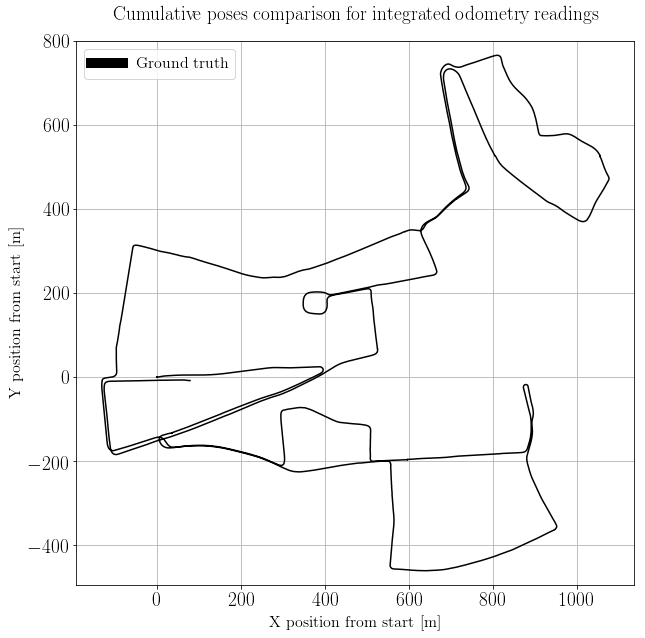

In [658]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)

# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

(20000, 40000)

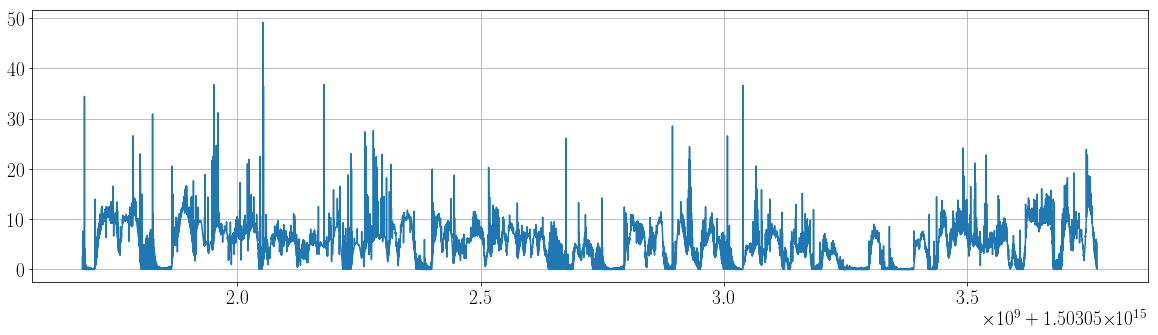

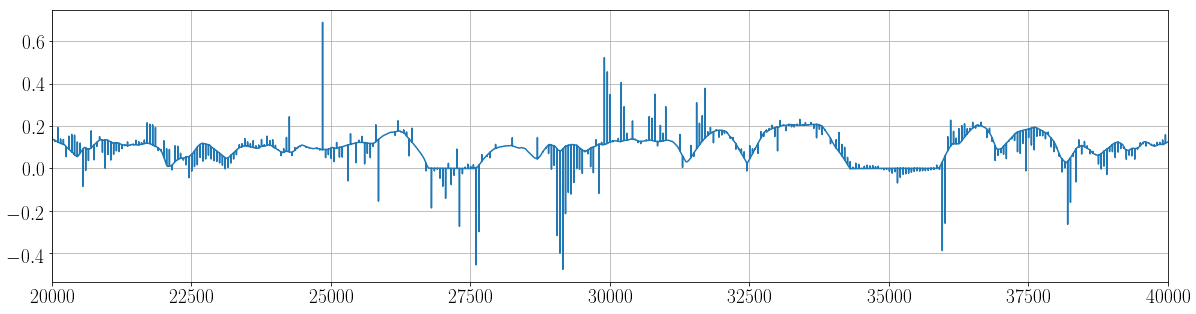

In [659]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_x_vals = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(INS_timestamps)):
# for i in range(1000,2000):
    INS_x_vals.append(INS_se3s[i][0,3])
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.figure(figsize=(20,5))
plt.plot(INS_TIMESTAMPS,INS_speeds);

plt.figure(figsize=(20,5))
plt.plot(INS_x_vals);
plt.xlim(20000,40000)

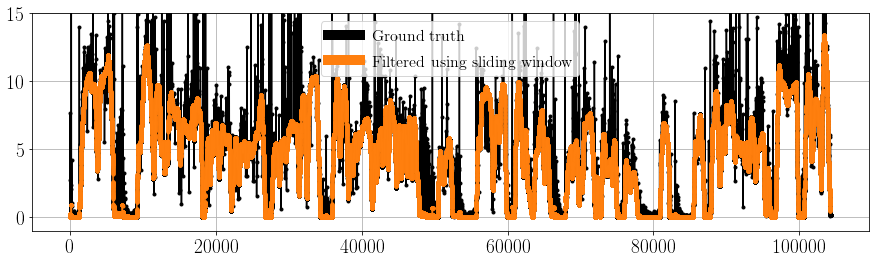

In [660]:
window_size = 40
std_devs = []
means = []
n_sigmas = 2

for i in range(window_size//2,len(INS_speeds)-window_size//2):
    window_contents = INS_speeds[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

x_start = 0 #1000
x_end = len(INS_speeds) #1500

plt.figure(figsize=(15,4))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1)
# plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
# plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

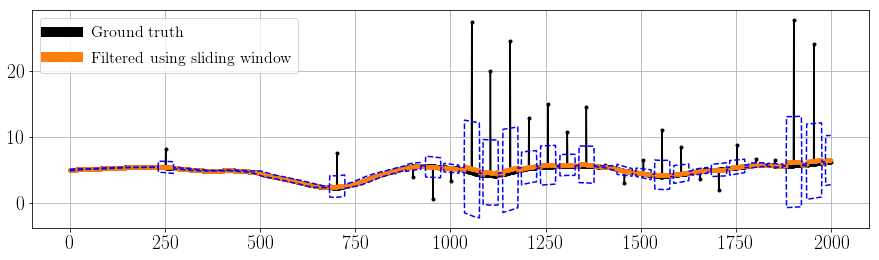

In [661]:
# x_start = 0 #1000
# x_end = len(INS_speeds) #1500

x_start = 28000
x_end = 30000

plt.figure(figsize=(15,4))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1)
plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

# plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

(-1, 15)

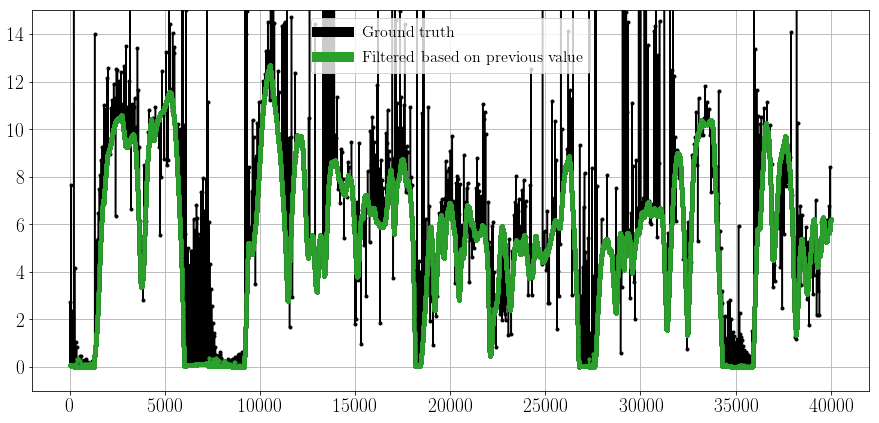

In [662]:
# x_start = 0 #1000
# x_end = len(INS_speeds) #1500
x_start = 0 #1000
x_end = 40000

speed_threshold = 0.1
INS_tamed = np.array(INS_speeds)
for i in range (1,len(INS_speeds)):
    if(np.abs(INS_speeds[i] - INS_speeds[i-1]) > speed_threshold):
        INS_tamed[i] = INS_tamed[i-1]
        
plt.figure(figsize=(15,7))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(INS_tamed[x_start:x_end],'.-',color=colour_aux_2)
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_2,label='Filtered based on previous value',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')
plt.ylim(-1,15)

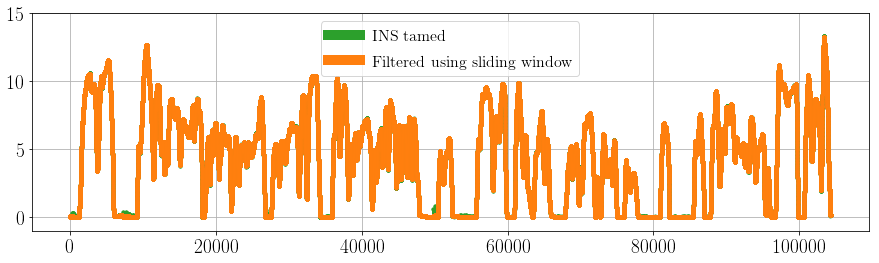

In [663]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2

for i in range(window_size//2,len(INS_tamed)-window_size//2):
    window_contents = INS_tamed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

x_start = 0 #1000
x_end = len(INS_speeds) #1500

plt.figure(figsize=(15,4))
plt.plot(INS_tamed[x_start:x_end],'.-',color=colour_aux_2)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1)
# plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
# plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_aux_2,label='INS tamed',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

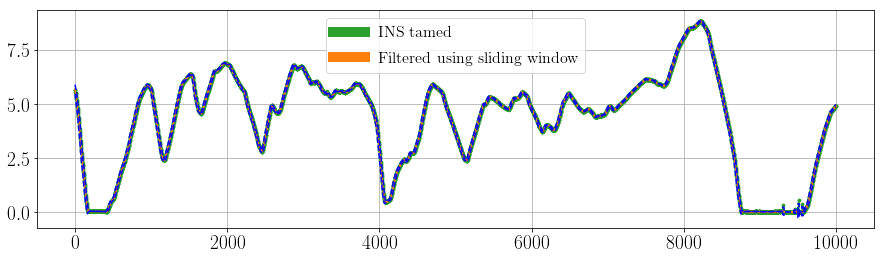

In [664]:
x_start = 18000 #1000
x_end = 28000

plt.figure(figsize=(15,4))
plt.plot(INS_tamed[x_start:x_end],'.-',color=colour_aux_2,MarkerSize=5.0)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1,MarkerSize=0.1)
plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

# plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_aux_2,label='INS tamed',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

In [667]:
print(len(INS_timestamps))
print(len(INS_se3s_tamed))

104301
104300


(20000, 40000)

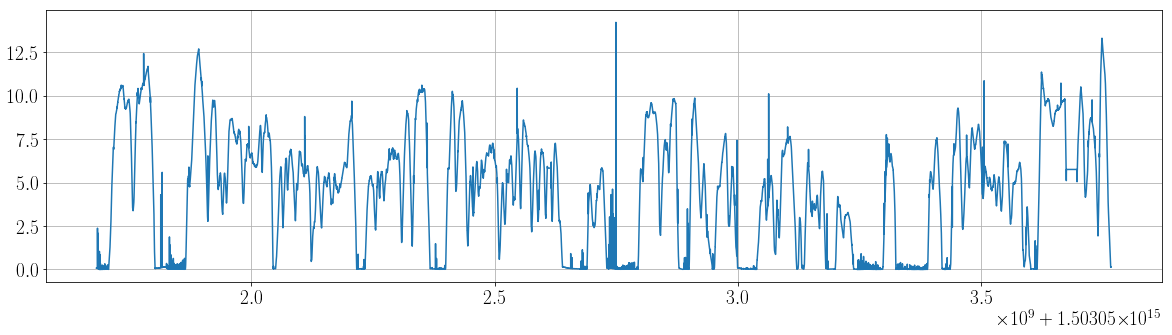

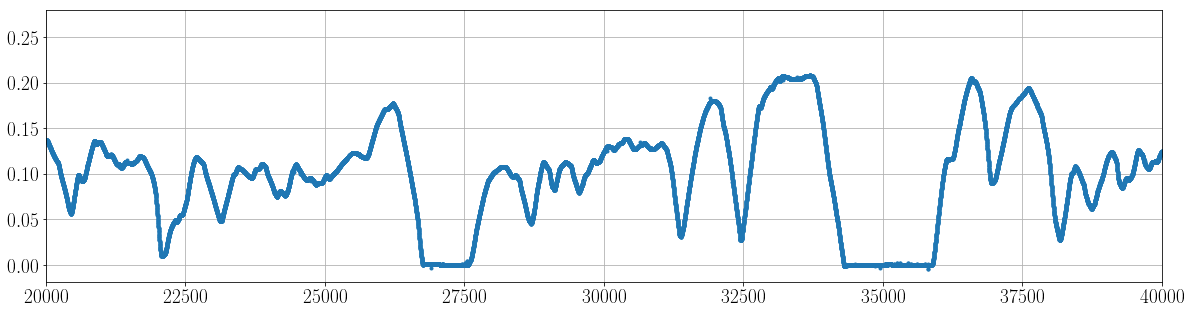

In [668]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_se3s_tamed = []
INS_x_vals = []
INS_TIMESTAMPS = []
deltatime_arr = []

# This is critical, otherwise we risk editing INS_se3s elements
for i in range(1,len(INS_se3s)):
    INS_se3s_tamed.append((np.matrix(INS_se3s[i])))

for i in range(1,len(INS_se3s_tamed)):
# for i in range(10000,12000):    
    # do some preprocessing correction
    if(np.abs(INS_se3s_tamed[i][0,3] - INS_se3s_tamed[i-1][0,3]) > 0.005):
        INS_se3s_tamed[i] = INS_se3s_tamed[i-1]
#         INS_se3s_tamed[i][0,3] = INS_se3s_tamed[i-1][0,3]
#         INS_se3s_tamed[i][1,3] = INS_se3s_tamed[i-1][1,3]

    INS_x_vals.append(INS_se3s_tamed[i][0,3])

    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s_tamed[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.figure(figsize=(20,5))
plt.plot(INS_TIMESTAMPS,INS_speeds);

plt.figure(figsize=(20,5))
plt.plot(INS_x_vals,'.');
plt.xlim(20000,40000)

In [669]:
INS_se3s[10000][0,3] - INS_se3s[10000-1][0,3]

0.00022044815705157816

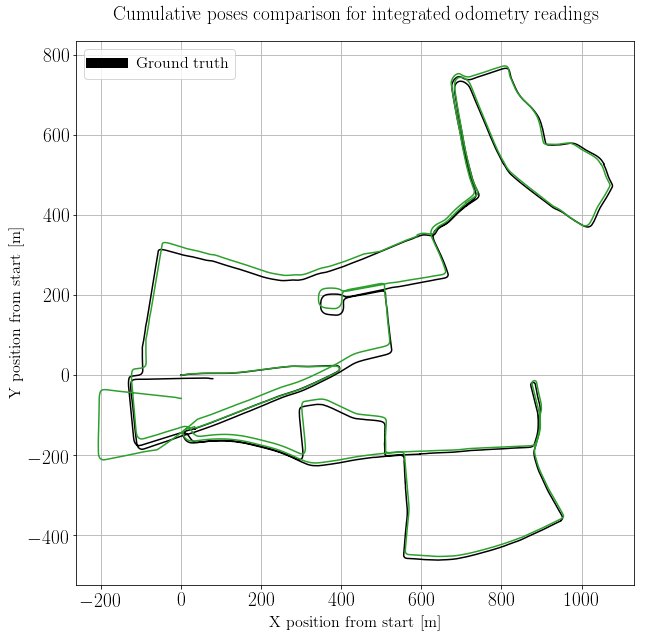

In [670]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get tamed INS poses
INS_poses_tamed = []
pose_tamed = np.identity(4)
for i in range(len(INS_se3s_tamed)):
    pose_tamed = pose_tamed * INS_se3s_tamed[i]
    INS_poses_tamed.append(pose_tamed)

# get x,y coords
x_INS_tamed = [pose_tamed[0, 3] for pose_tamed in INS_poses_tamed]
y_INS_tamed = [pose_tamed[1, 3] for pose_tamed in INS_poses_tamed]
# downsample INS for figure rendering
x_INS_tamed_lite = x_INS_tamed[::10]
y_INS_tamed_lite = y_INS_tamed[::10]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.plot(x_INS_tamed_lite,y_INS_tamed_lite,'-',color=colour_aux_2,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)

# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

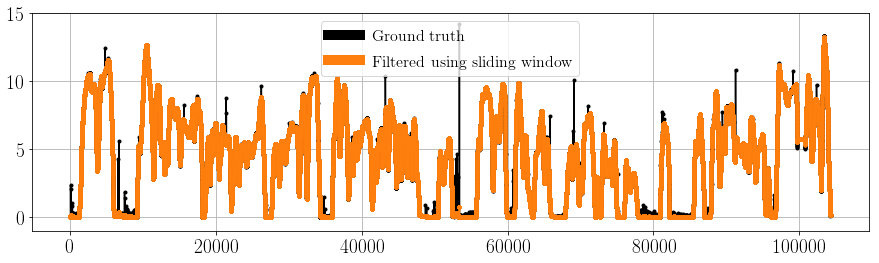

In [671]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2

for i in range(window_size//2,len(INS_speeds)-window_size//2):
    window_contents = INS_speeds[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

x_start = 0 #1000
x_end = len(INS_speeds) #1500

plt.figure(figsize=(15,4))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1)
# plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
# plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

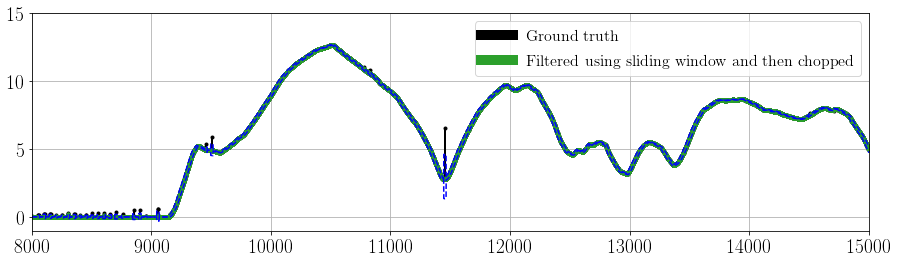

In [672]:
n_sigmas = 2
x_start = 0 #1000
x_end = len(INS_speeds) #1500
INS_speeds_filt = list(INS_speeds)
for i in range(1,len(std_devs)):
    if INS_speeds_filt[i] < means[i]-n_sigmas*std_devs[i] or INS_speeds_filt[i] > means[i]+n_sigmas*std_devs[i]:
        INS_speeds_filt[i] = INS_speeds_filt[i-1]
#     if(np.abs(INS_speeds_filt[i]) < 0.1):
#         INS_speeds_filt[i] = 0.0

plt.figure(figsize=(15,4))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(INS_speeds_filt[x_start:x_end],'.-',color=colour_aux_2)
plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

# plt.ylim(-0.5,0.5)
plt.ylim(-1,15)
plt.xlim(8000,15000)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_2,label='Filtered using sliding window and then chopped',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

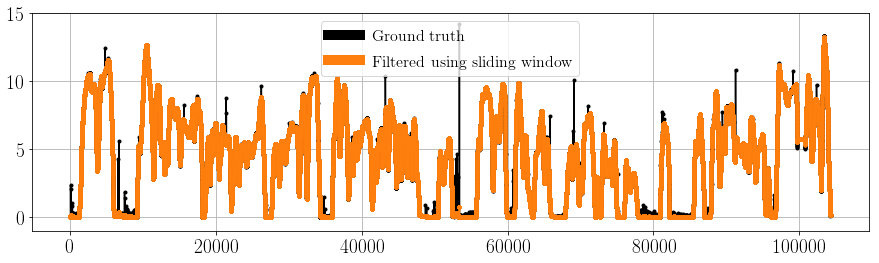

In [673]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2

for i in range(window_size//2,len(INS_speeds)-window_size//2):
    window_contents = INS_speeds[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

x_start = 0 #1000
x_end = len(INS_speeds) #1500

plt.figure(figsize=(15,4))
plt.plot(INS_speeds[x_start:x_end],'.-',color=colour_ins)
plt.plot(means[x_start:x_end],'.-',color=colour_aux_1)
# plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
# plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

plt.ylim(-1,15)
# plt.xlim(100,300)

line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_1,label='Filtered using sliding window',linewidth=10.0)
plt.legend(handles=[line1,line2],loc='best')

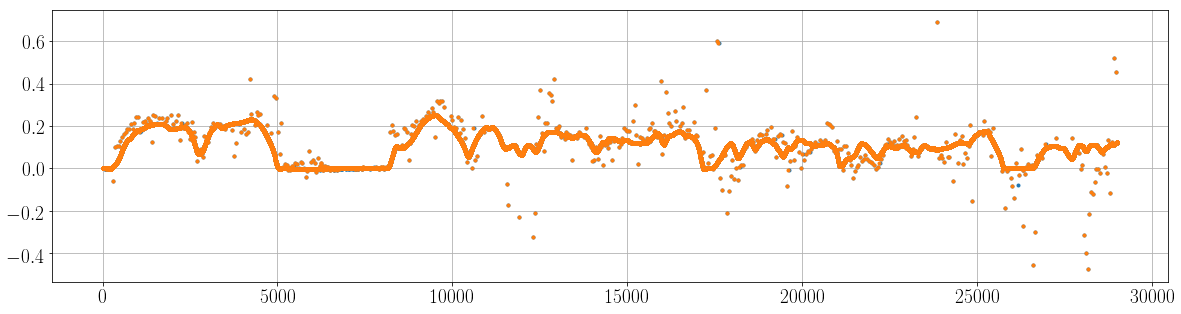

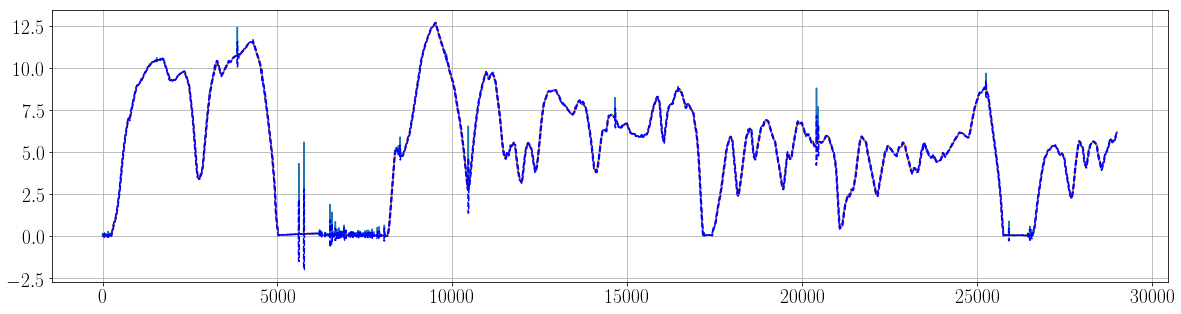

In [681]:
INS_speeds_tamed = list(INS_speeds)
INS_se3s_tamed = []
INS_x_vals = []
INS_x_vals_tamed = []

# This is critical, otherwise we risk editing INS_se3s elements
for i in range(1,len(INS_se3s)):
    INS_se3s_tamed.append((np.matrix(INS_se3s[i])))

for i in range(1,len(std_devs)):
    if (INS_speeds[i-1] < (means[i-1]-n_sigmas*std_devs[i-1]) or INS_speeds[i-1] > (means[i-1]+n_sigmas*std_devs[i-1])):
        # index offset is because the pose is responsible for the speed from the previous index
        INS_se3s_tamed[i] = INS_se3s_tamed[i-1];            

    INS_x_vals.append(INS_se3s[i][0,3])
    INS_x_vals_tamed.append(INS_se3s_tamed[i][0,3] +0.0)

x_start = 1000
x_end = 30000

plt.figure(figsize=(20,5))
plt.plot(INS_x_vals[x_start:x_end],'.');
plt.plot(INS_x_vals_tamed[x_start:x_end],'.');

plt.figure(figsize=(20,5))
plt.plot(INS_speeds[x_start:x_end]);
plt.plot(means[x_start:x_end]);
plt.plot(means[x_start:x_end]+n_sigmas*std_devs[x_start:x_end],'b--')
plt.plot(means[x_start:x_end]-n_sigmas*std_devs[x_start:x_end],'b--')

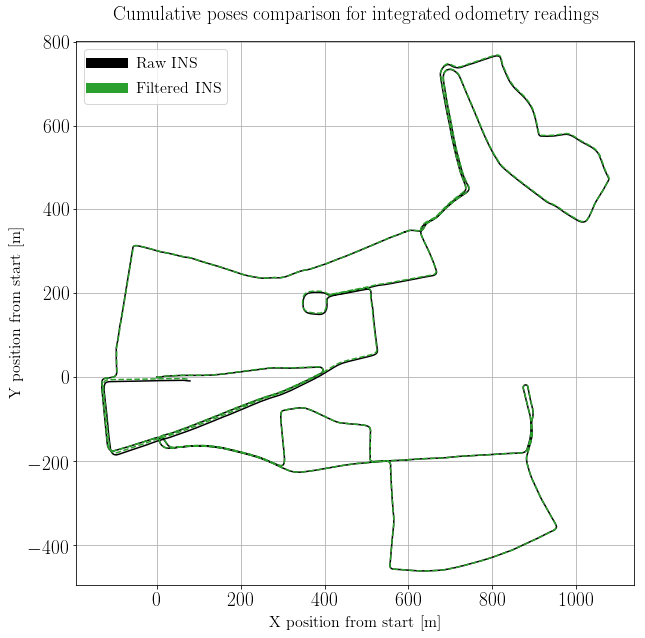

In [675]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get tamed INS poses
INS_poses_tamed = []
pose_tamed = np.identity(4)
for i in range(len(INS_se3s_tamed)):
    pose_tamed = pose_tamed * INS_se3s_tamed[i]
    INS_poses_tamed.append(pose_tamed)

# get x,y coords
x_INS_tamed = [pose_tamed[0, 3] for pose_tamed in INS_poses_tamed]
y_INS_tamed = [pose_tamed[1, 3] for pose_tamed in INS_poses_tamed]
# downsample INS for figure rendering
x_INS_tamed_lite = x_INS_tamed[::10]
y_INS_tamed_lite = y_INS_tamed[::10]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.plot(x_INS_tamed_lite,y_INS_tamed_lite,'--',color=colour_aux_2,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Raw INS',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_2,label='Filtered INS',linewidth=10.0)


# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1,line2],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)